
# Rozpoznawanie Cyfr Pisanych Odręcznie

W tym notatniku zajmiemy się problemem rozpoznawania cyfr pisanych odręcznie. Skorzystamy z konwolucyjnych sieci neuronowych (CNN), które są doskonałe do przetwarzania obrazów. Wykorzystamy zbiór danych MNIST, który jest standardowym benchmarkiem w tej dziedzinie.


In [1]:

# Tworzenie modelu
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Do analizy modelu
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns



## Załadowanie i Przygotowanie Danych

Zaczniemy od załadowania zbioru danych MNIST, który zawiera tysiące obrazów ręcznie pisanych cyfr.

Zbiór danych MNIST składa się z obrazów cyfr pisanych odręcznie. Każdy obraz ma wymiary 28x28 pikseli, gdzie każdy piksel reprezentuje intensywność koloru w skali szarości (0 oznacza biały, 255 - czarny). Nie ma tutaj dodatkowych atrybutów oprócz samych pikseli obrazu.

Dzielenie przez 255 skaluje te wartości do zakresu 0-1. Skalowanie do mniejszego zakresu danych ułatwia proces uczenia przez zapewnienie jednorodności danych i poprawę stabilności gradientów.


In [2]:

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalizacja obrazów
train_images, test_images = train_images / 255.0, test_images / 255.0



## Eksploracja Danych

Przyjrzymy się przykładowym obrazom z naszego zbioru danych.


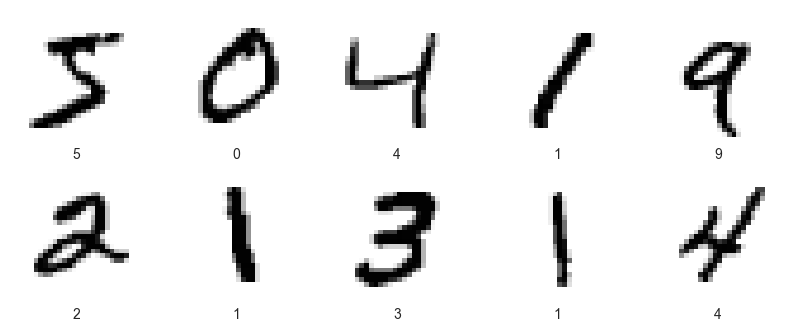

In [3]:

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()



## Przetwarzanie Wstępne Danych

Przygotujemy dane do procesu uczenia, w tym kształt obrazów i etykiet.

1. Operacja reshape((60000, 28, 28, 1)) na zestawie danych obrazów jest stosowana do zmiany ich kształtu tak, aby pasowały do oczekiwań wejściowych modelu sieci neuronowej. W przypadku tego konkretnego modelu:
    - 60000 i 10000 to liczba obrazów w zestawach danych treningowych i testowych.
    - 28, 28 to wymiary każdego obrazu (wysokość i szerokość).
    - 1 oznacza liczbę kanałów kolorów w obrazie. W przypadku obrazów w skali szarości, jak w MNIST, jest tylko jeden kanał. Dla obrazów RGB byłoby to 3 (po jednym dla czerwonego, zielonego i niebieskiego).

2. W kontekście MNIST, typ kategoryczny odnosi się do etykiet - są to cyfry od 0 do 9, które odpowiadają narysowanej cyfrze na obrazie. Te etykiety są już zakodowane w postaci kategorii w modelu poprzez zastosowanie funkcji to_categorical.
    - Funkcja to_categorical konwertuje jednowymiarowe tablice etykiet na format "one-hot encoding". "One-hot encoding" to metoda, w której każda etykieta jest reprezentowana jako wektor binarny. W tym wektorze, wszystkie elementy są ustawione na 0, z wyjątkiem indeksu odpowiadającego etykiecie, który jest ustawiony na 1.
    - Na przykład, jeśli mamy etykietę 2, po konwersji na "one-hot" będzie wyglądała tak: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]. Tutaj, trzeci element (licząc od zera) jest ustawiony na 1, co odpowiada cyfrze '2'.
    - Ta konwersja jest niezbędna, ponieważ sieć neuronowa, którą używamy do klasyfikacji, lepiej radzi sobie z etykietami w formacie "one-hot".


In [4]:

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Konwersja etykiet na kategorie
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)



## Budowa Modelu CNN

Tworzymy model konwolucyjnej sieci neuronowej (CNN - Convolutional Neural Network), który będzie składał się z kilku warstw, w tym warstw konwolucyjnych i warstw gęsto połączonych.

- `models.Sequential`: Tworzy sekwencyjny model sieci neuronowej, gdzie każda warstwa jest dodawana kolejno. W modelach sekwencyjnych dane przechodzą przez jedną warstwę, a następnie są przekazywane do następnej.

- `layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))`: Jest to konwolucyjna warstwa (Conv2D) z 32 filtrami, gdzie `(3, 3)` określa rozmiar każdego filtra (3x3), `activation='relu'` wskazuje, że jako funkcję aktywacji wykorzystuje się ReLU (Rectified Linear Unit), a `input_shape=(28, 28, 1)` określa kształt danych wejściowych (obrazy 28x28 z jednym kanałem kolorów - skala szarości).

- `layers.MaxPooling2D((2, 2))`: Warstwa MaxPooling redukuje rozmiar reprezentacji obrazu poprzez wybieranie maksymalnej wartości z określonych obszarów (tutaj obszary 2x2 piksele).

- `layers.Conv2D(64, (3, 3), activation='relu')`: Kolejna warstwa konwolucyjna, tym razem z 64 filtrami o rozmiarze 3x3, również z funkcją aktywacji ReLU.

- `layers.MaxPooling2D((2, 2))`: Kolejna warstwa MaxPooling, ponownie redukująca rozmiar reprezentacji obrazu.

- `layers.Conv2D(64, (3, 3), activation='relu')`: Jeszcze jedna warstwa konwolucyjna z 64 filtrami i funkcją aktywacji ReLU.

- `layers.Flatten()`: Warstwa spłaszczająca, która konwertuje dane z 2D (obraz) na 1D (wektor), aby mogły być przetworzone przez standardowe (gęste) warstwy sieci neuronowej.

- `layers.Dense(64, activation='relu')`: Gęsta warstwa (Dense) z 64 neuronami i funkcją aktywacji ReLU.

- `layers.Dense(10, activation='softmax')`: Ostatnia gęsta warstwa z 10 neuronami, co odpowiada liczbie klas (0-9) w zestawie danych MNIST. Używa funkcji aktywacji 'softmax', która jest odpowiednia do klasyfikacji wieloklasowej i przekształca wyjście sieci w rozkład prawdopodobieństwa.

ReLU (Rectified Linear Unit):
- ReLU(x) = max(0, x). Funkcja ta zwraca x, jeśli x jest dodatni, lub 0 w przeciwnym wypadku.

Softmax:
- Softmax konwertuje wektor logitów (np. wyników z warstwy Dense w sieci neuronowej) na rozkład prawdopodobieństwa. Dla wektora z, Softmax(z)_i = exp(z_i) / sum(exp(z_j)) dla każdego i i j.

In [5]:

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])



## Kompilacja Modelu

Określimy optymalizator, funkcję straty i metryki do oceny modelu:
1. Optimizer (Optymalizator)
    - `optimizer='adam'` oznacza, że model używa optymalizatora Adam do aktualizacji wag sieci w procesie uczenia.
    - **Adam (Adaptive Moment Estimation):** Jest zaawansowanym optymalizatorem, który łączy idee z RMSprop i Gradient Descent z momentum. Jest powszechnie używany ze względu na swoją efektywność w różnych zadaniach uczenia maszynowego.
2. Loss Function (Funkcja strat)
    - `loss='categorical_crossentropy'` wskazuje, że używana jest kategoryczna entropia krzyżowa jako funkcja straty.
    - **Kategoryczna entropia krzyżowa:** Stosowana w problemach klasyfikacji wieloklasowej, mierzy "odległość" między rzeczywistym rozkładem etykiet a przewidywaniami modelu, z celem jej minimalizacji.
3. Metrics (Metryki)
    - `metrics=['accuracy']` określa, że dokładność (accuracy) jest śledzona jako metryka podczas procesu trenowania.
    - **Accuracy:** To stosunek liczby poprawnie zaklasyfikowanych próbek do całkowitej liczby próbek. Jest to intuicyjna i często stosowana metryka do oceny wydajności modelu w zadaniach klasyfikacyjnych.


In [6]:

model.compile (
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



## Trenowanie Modelu

Przeprowadzimy proces uczenia modelu na danych treningowych.
1. train_images i train_labels
    - train_images: Zestaw danych zawierający obrazy, które są wykorzystywane do trenowania modelu.
    - train_labels: Etykiety odpowiadające train_images, które model próbuje przewidzieć.
2. epochs=5
    - epochs: Określa liczbę przebiegów przez cały zestaw treningowy. W tym przypadku model będzie przetwarzał cały zestaw danych treningowych 5 razy.
3. validation_data=(test_images, test_labels)
    - validation_data: Dane używane do walidacji modelu po każdej epoce. Pozwala to na monitorowanie wydajności modelu na danych, których nie widział podczas treningu, co jest kluczowe do sprawdzenia, czy nie występuje zjawisko przeuczenia (overfitting).
    - test_images i test_labels: To zestaw danych testowych (nieuczestniczących w treningu), które są używane do oceny modelu.

In [7]:

history = model.fit (
    train_images,
    train_labels,
    epochs=5,
    validation_data=(test_images, test_labels)
)


Epoch 1/5
1875/1875 [==============================] - 20s 10ms/step - loss: 0.1466 - accuracy: 0.9538 - val_loss: 0.0483 - val_accuracy: 0.9835
Epoch 2/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0451 - accuracy: 0.9859 - val_loss: 0.0461 - val_accuracy: 0.9843
Epoch 3/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0335 - accuracy: 0.9892 - val_loss: 0.0328 - val_accuracy: 0.9889
Epoch 4/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0250 - accuracy: 0.9922 - val_loss: 0.0285 - val_accuracy: 0.9911
Epoch 5/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.0283 - val_accuracy: 0.9917



## Ocena Modelu

Po wytrenowaniu modelu ocenimy jego wydajność na zbiorze testowym.


In [8]:

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(f'Test accuracy: {test_acc * 100}%')


313/313 - 2s - loss: 0.0283 - accuracy: 0.9917 - 2s/epoch - 8ms/step
Test accuracy: 99.16999936103821%



## Wyświetlanie obrazów testowych i predykcje modelu

Poniżej wyświetlamy 10 obrazów z zestawu testowego wraz z przewidywaniami modelu dotyczącymi każdego z nich.

1/1 [==============================] - 0s 296ms/step


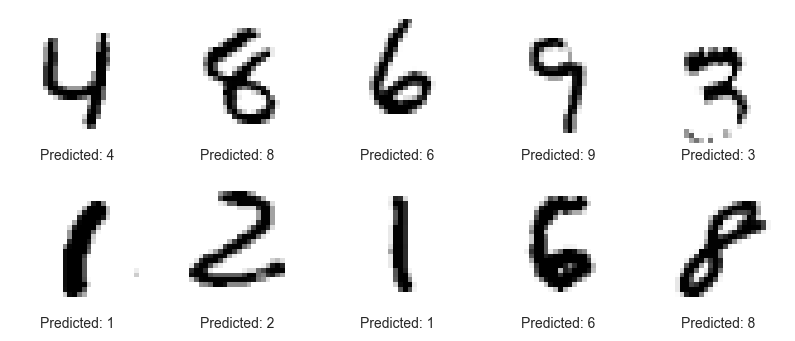

In [9]:

# Wybieranie losowych 10 obrazów z zestawu testowego
random_indices = random.sample(range(len(test_images)), 10)
test_images_sample = np.array([test_images[i] for i in random_indices])

# Przewidywanie etykiet dla wybranych obrazów
predicted_labels = model.predict(test_images_sample)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Wyświetlanie obrazów i przewidywań
plt.figure(figsize=(10, 4))
for i in range(len(test_images_sample)):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images_sample[i], cmap=plt.cm.binary)
    plt.xlabel(f'Predicted: {predicted_labels[i]}')
plt.show()


## Macierz pomyłek

Macierz pomyłek to narzędzie używane do oceny wydajności algorytmu klasyfikacji. Każdy wiersz macierzy reprezentuje rzeczywiste klasy, a każda kolumna przewidywane klasy. Poniżej przedstawiamy kod do wygenerowania macierzy pomyłek dla naszego modelu na danych testowych.


313/313 [==============================] - 2s 6ms/step


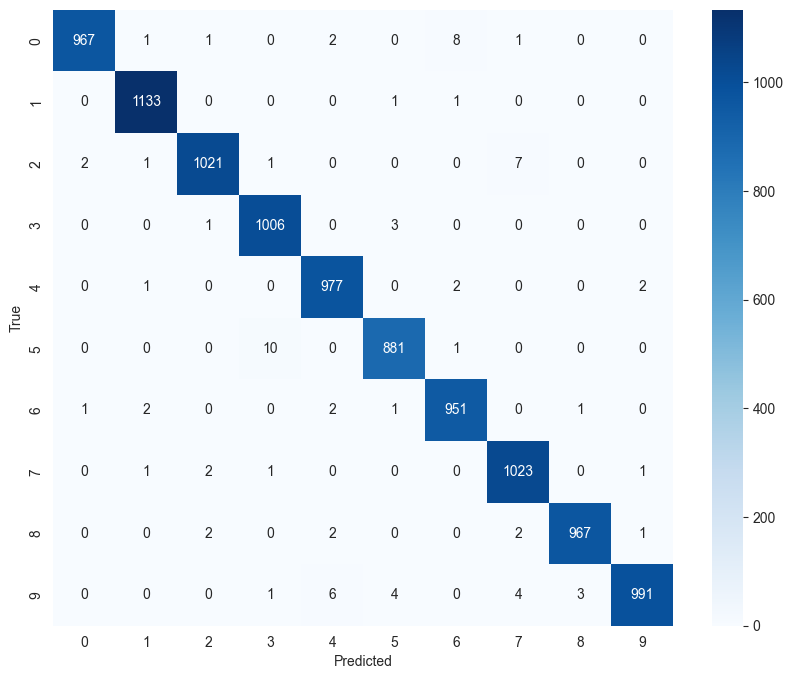

In [10]:

# Przewidywanie etykiet dla danych testowych
predicted_labels_test = model.predict(test_images)
predicted_labels_test = np.argmax(predicted_labels_test, axis=1)
true_labels_test = np.argmax(test_labels, axis=1)

# Tworzenie macierzy pomyłek
cm = confusion_matrix(true_labels_test, predicted_labels_test)

# Wyświetlanie macierzy pomyłek
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Analiza błędów

Identyfikacja i analiza przypadków, w których model popełnia błędy, aby zrozumieć, w jakich warunkach model nie działa prawidłowo.

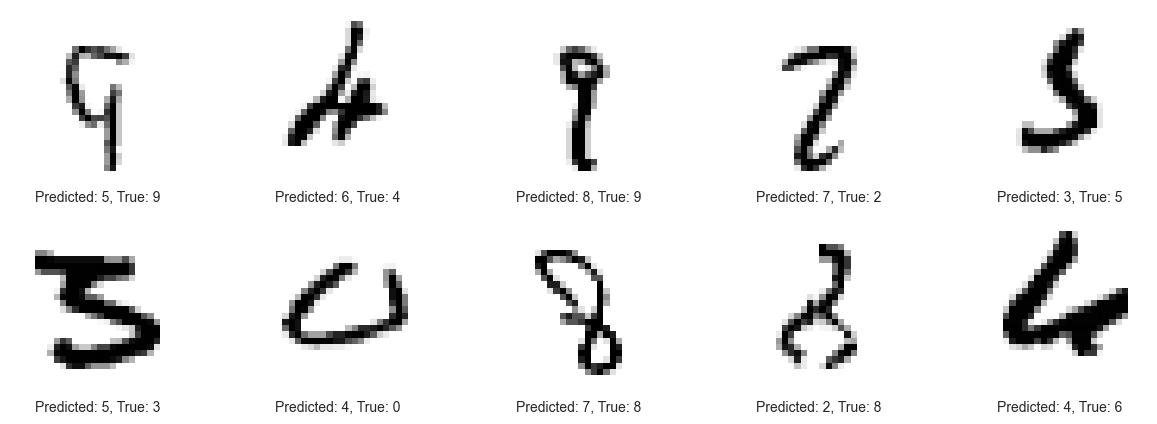

In [11]:

incorrect_indices = np.where(predicted_labels_test != true_labels_test)[0]
incorrect_samples = test_images[incorrect_indices]
incorrect_predictions = predicted_labels_test[incorrect_indices]

plt.figure(figsize=(15, 5))
for i, incorrect in enumerate(incorrect_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(incorrect_samples[i], cmap=plt.cm.binary)
    plt.xlabel(f'Predicted: {incorrect_predictions[i]}, True: {true_labels_test[incorrect]}')
plt.show()



## Wnioski

W tym notatniku zbudowaliśmy i wytrenowaliśmy prosty model sieci neuronowej do rozpoznawania cyfr pisanych odręcznie. Model ten został przetestowany na zestawie danych MNIST.

Macierz pomyłek wskazuje na podwyższoną tendencję (w ogólnym rozrachunku jest bardzo niska, ale wyróżnia się na tle) w rozpoznawaniu danej cyfry jako innej. Jest to zrozumiałe, gdyż cyfry te są do siebie stosunkowo podobne.

Po wglądzie w błędne predykcje modelu, widzimy, że miały one miejsce dla cyfr bardzo niewyraźnych i nawet człowiek z niektórymi mógłby mieć problem. 

Model wykazał satysfakcjonującą skuteczność ponad 99%. Ten projekt stanowi podstawowy przykład wykorzystania sieci neuronowych w przetwarzaniu obrazów, demonstrując, jak techniki uczenia maszynowego mogą być skutecznie stosowane do rozpoznawania wzorców w danych wizualnych.